# Φάση 2: Σημασιολογική ανάκτηση χρησιμοποιώντας Transformers1 και FAISS

## Εισαγωγή
Η παρούσα εργασία εστιάζει στην υλοποίηση ενός συστήματος ανάκτησης πληροφορίας που βασίζεται στη **σημασιολογική ομοιότητα** και όχι στην απλή λεκτική αντιστοίχιση. Στόχος είναι η ανάκτηση σχετικών επιστημονικών περιλήψεων από τη βάση δεδομένων, απαντώντας σε σύνθετες τεχνικές ερωτήσεις.

Η προσέγγισή μας χρησιμοποιεί **Neural Embeddings**, επιτρέποντας στο σύστημα να "καταλαβαίνει" το νόημα, τις συνώνυμες έννοιες και το τεχνικό πλαίσιο.

## Αρχιτεκτονική Συστήματος
Η ροή εργασιών που υλοποιείται στον κώδικα ακολουθεί τα εξής βήματα:

1.  **Προεπεξεργασία:**
    * Εφαρμόζεται στρατηγικός καθαρισμός κειμένου.
    * **Καινοτομία:** Επιλέχθηκε η διατήρηση σημαντικών συμβόλων μέσω whitelist regex, καθώς σε τεχνικά κείμενα προσδίδουν κρίσιμη σημασιολογική πληροφορία.

2.  **Διανυσματοποίηση:**
    * Χρήση ισχυρών προ-εκπαιδευμένων μοντέλων Transformer (SBERT: `all-MiniLM-L6-v2`).
    * Τα κείμενα μετατρέπονται σε πυκνά διανύσματα (Dense Vectors) που αποτυπώνουν το νόημά τους σε έναν πολυδιάστατο χώρο.

3.  **Ευρετηρίαση & Αναζήτηση:**
    * Χρήση της βιβλιοθήκης **FAISS** (Facebook AI Similarity Search) για ταχύτατη αναζήτηση.
    * Υπολογισμός ομοιότητας με τη μέθοδο **Cosine Similarity** (μέσω Inner Product σε κανονικοποιημένα διανύσματα).

4.  **Αξιολόγηση & Οπτικοποίηση:**
    * Ποσοτική αξιολόγηση με το πρότυπο **TREC** και υπολογισμός μετρικών (MAP, Precision@k, Recall).
    * Ποιοτικός έλεγχος με οπτικοποίηση του διανυσματικού χώρου μέσω μείωσης διαστάσεων (PCA), ώστε να φανεί η συσταδοποίηση των αποτελεσμάτων γύρω από την ερώτηση.

---

In [1]:
%pip install torch sentence-transformers faiss-cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Εισάγουμε τις απαραίτητες βιβλιοθήκες και ορίζουμε τις διαδρομές των αρχείων.
Επιλέγουμε το Pre-trained μοντέλο που θα μετατρέψει τα κείμενα σε διανύσματα.

In [2]:
import pandas as pd
import numpy as np
import os
import subprocess
import re
import html
import unicodedata
import faiss
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, auc

DOCS_PATH = "../data/documents.csv"
QUERIES_PATH = "../data/queries.csv"
QRELS_PATH = "../data/qrels.txt"
TREC_EVAL_PATH = "../../trec_eval/trec_eval.exe"  
RESULTS_DIR = "../results/results_phase2"

MODEL_NAME = 'all-MiniLM-L6-v2'

## Προεπεξεργασία και Φόρτωση Δεδομένων

Σε αυτό το βήμα ορίζουμε τη συνάρτηση καθαρισμού `clean_for_phase2` και φορτώνουμε τα δεδομένα εγγράφων και ερωτήσεων.

**Βασικά σημεία της προεπεξεργασίας:**
* **HTML Decoding (`html.unescape`):** Μετατρέπουμε κωδικοποιημένους χαρακτήρες (όπως `&amp;`, `&gt;`) στην κανονική τους μορφή (`&`, `>`). Αυτό είναι κρίσιμο για να διατηρηθεί το νόημα σε εκφράσεις όπως "R&D" ή συγκρίσεις τιμών.
* **Normalization (`NFKC`):** Κανονικοποιούμε τους χαρακτήρες Unicode για ομοιομορφία.
* **Διατήρηση Συμβόλων:** Επιλέξαμε να **μην αφαιρέσουμε** τους ειδικούς χαρακτήρες (μέσω Regex), καθώς σύμβολα όπως τα `%`, `$`, `&` περιέχουν σημαντική σημασιολογική πληροφορία για τεχνικά κείμενα.
* **Lowercase:** Μετατροπή όλων σε πεζά για μείωση της πολυπλοκότητας του λεξιλογίου.

Τέλος, τα δεδομένα φορτώνονται σε Pandas DataFrames και δημιουργείται η στήλη `clean_text` που θα χρησιμοποιηθεί για την παραγωγή των embeddings.

In [3]:
def clean_for_phase2(text):
    if not isinstance(text, str): return ""
    text = html.unescape(text)
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.,\?!:;@%#\+\-&<>]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def load_data():
    try:
        # Documents
        df_docs = pd.read_csv(DOCS_PATH)
        df_docs.columns = ['ID', 'Text'] 
        df_docs['clean_text'] = df_docs['Text'].apply(clean_for_phase2)
        
        # Queries
        df_queries = pd.read_csv(QUERIES_PATH)
        df_queries.columns = ['ID', 'Text'] 
        df_queries['clean_text'] = df_queries['Text'].apply(clean_for_phase2)
        
        return df_docs, df_queries
    except Exception as e:
        print(e)
        return None, None

## Οπτικοποίησης

Η κλάση `SemanticVisualizer` είναι υπεύθυνη για τη γραφική αναπαράσταση των διανυσμάτων (embeddings) στον δισδιάστατο χώρο. Επειδή τα διανύσματα έχουν πολλές διαστάσεις (384), χρησιμοποιούμε την τεχνική **PCA (Principal Component Analysis)** για να μειώσουμε τις διαστάσεις σε 2, ώστε να μπορούμε να τα σχεδιάσουμε.

Η κλάση διαθέτει δύο βασικές λειτουργίες:

1.  **`plot_single_query` (Semantic Zoom):**
    * Εστιάζει σε **μία** συγκεκριμένη ερώτηση και τα Top-K αποτελέσματά της.
    * Χρησιμοποιεί χρωματική κλίμακα για να δείξει την ομοιότητα.
    * Μας επιτρέπει να δούμε οπτικά πόσο "κοντά" είναι τα έγγραφα που ανακτήθηκαν στην ερώτηση που είναι το κόκκινο αστέρι.

2.  **`plot_multi_query` (Semantic Universe):**
    * Προβάλλει **πολλές ερωτήσεις ταυτόχρονα** μαζί με τα τοπ 20 έγγραφά τους.
    * Χρησιμοποιεί διαφορετικά χρώματα για κάθε ερώτηση.
    * Βοηθάει να κατανοήσουμε αν οι ερωτήσεις διαχωρίζονται σωστά στον χώρο και αν υπάρχει επικάλυψη θεματολογίας.

> Η κλάση δέχεται ως ορίσματα τα ήδη υπολογισμένα αποτελέσματα (`D`, `I`), ώστε να μην χρειάζεται να εκτελεστεί ξανά η διαδικασία της αναζήτησης για κάθε διάγραμμα.

In [4]:
class SemanticVisualizer:
    def __init__(self, model, df_docs, df_queries, doc_embeddings, D, I):

        self.model = model
        self.df_docs = df_docs
        self.df_queries = df_queries
        self.doc_embeddings = doc_embeddings 
        self.D = D             
        self.I = I             
        
        self.text_col = 'clean_text' if 'clean_text' in df_docs.columns else 'Text'

    def plot_single_query(self, query_id, k=50):  
        q_idx_list = self.df_queries.index[self.df_queries['ID'] == query_id].tolist()
        if not q_idx_list:
            print("Query not found!")
            return
        q_idx = q_idx_list[0]

        indices = self.I[q_idx, :k]
        scores = self.D[q_idx, :k]
        
        q_text = self.df_queries.iloc[q_idx][self.text_col]
        q_emb = self.model.encode([q_text], normalize_embeddings=True)
        
        retrieved_doc_embs = self.doc_embeddings[indices]

        all_vectors = np.vstack([q_emb, retrieved_doc_embs])
        pca = PCA(n_components=2)
        coords = pca.fit_transform(all_vectors)

        plt.figure(figsize=(10, 8))
        sc = plt.scatter(coords[1:, 0], coords[1:, 1], c=scores, cmap='viridis', s=100, alpha=0.8, label='Documents', edgecolors='k')
        plt.colorbar(sc, label='Cosine Similarity')
        plt.scatter(coords[0, 0], coords[0, 1], c='red', marker='*', s=400, label=f'Query {query_id}', edgecolors='black', zorder=10)

        for i in range(1, 4):
            plt.annotate(f"Rank {i}", (coords[i, 0], coords[i, 1]), xytext=(5, 5), textcoords='offset points')

        plt.title(f"Semantic Zoom: Query {query_id}")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_multi_query(self, num_queries=10, k=30):
        queries_subset = self.df_queries.head(num_queries)
        all_vectors = []
        plot_data = []
        current_idx = 0

        for q_idx, row in queries_subset.iterrows():
            qid = str(row['ID'])
            q_text = row[self.text_col]
            
            q_emb = self.model.encode([q_text], normalize_embeddings=True)[0]
            
            indices = self.I[q_idx, :k]
            doc_embs = self.doc_embeddings[indices]
            
            all_vectors.append(q_emb)
            all_vectors.extend(doc_embs)
            
            plot_data.append({
                'q_idx': current_idx,
                'doc_start': current_idx + 1,
                'doc_end': current_idx + 1 + k,
                'qid': qid
            })
            current_idx += (1 + k)

        pca = PCA(n_components=2)
        coords = pca.fit_transform(np.array(all_vectors))
        
        plt.figure(figsize=(14, 10))
        colors = cm.tab10(np.linspace(0, 1, num_queries))

        for i, data in enumerate(plot_data):
            c = colors[i]
            plt.scatter(coords[data['q_idx'], 0], coords[data['q_idx'], 1], color=c, marker='*', s=300, edgecolors='black', label=f"Q: {data['qid']}", zorder=10)
            
            d_start, d_end = data['doc_start'], data['doc_end']
            plt.scatter(coords[d_start:d_end, 0], coords[d_start:d_end, 1], color=c, marker='o', s=60, alpha=0.5)
            
            for d_idx in range(d_start, d_end):
                plt.plot([coords[data['q_idx'], 0], coords[d_idx, 0]],
                         [coords[data['q_idx'], 1], coords[d_idx, 1]], color=c, alpha=0.15)

        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.title(f"Multi-Query Space (cached results)")
        plt.tight_layout()
        plt.show()

## Αξιολόγηση και Ποιοτικός Έλεγχος

Σε αυτή την ενότητα υλοποιούμε κρίσιμες συναρτήσεις για την επαλήθευση της απόδοσης του συστήματος:

### `save_and_eval_trec`
Αυτή η συνάρτηση αυτοματοποιεί τη διαδικασία της επίσημης αξιολόγησης.
* **Εξαγωγή Αποτελεσμάτων:** Μετατρέπει τα αποτελέσματα του FAISS (`I`, `D`) στην τυποποιημένη μορφή **TREC** (`qid Q0 docid rank score runid`) και τα αποθηκεύει σε αρχεία `.txt` για διαφορετικές τιμές του $k$ (π.χ. Top-20, Top-50).
* **Υπολογισμός Μετρικών:** Καλεί εξωτερικά το εργαλείο `trec_eval` και υπολογίζει αυτόματα:
    * **MAP (Mean Average Precision):** Η συνολική ποιότητα της κατάταξης.
    * **P@k (Precision at k):** Ακρίβεια στα πρώτα 5, 10, 15, 20 αποτελέσματα.
    * **Recall:** Πόσα από τα σχετικά έγγραφα καταφέραμε να βρούμε συνολικά.
    * **Επιστρέφει** τα raw αποτελέσματα (κείμενο) σε ένα λεξικό (`results_dict`), ώστε να μπορούν να χρησιμοποιηθούν από άλλες συναρτήσεις.

In [5]:
def save_and_eval_trec(D, I, df_docs, df_queries, k_list=[20, 30, 50]):
    os.makedirs(RESULTS_DIR, exist_ok=True)
    for k in k_list:

        print(f"\n Αποθήκευση αποτελεσμάτων για k={k}...")
        run_id = f"phase2_results_k{k}"
        output_file = os.path.join(RESULTS_DIR, f"{run_id}.txt")

        with open(output_file, 'w') as f:
            for q_idx, row in df_queries.iterrows():
                qid = str(row['ID'])
                current_indices = I[q_idx, :k]
                current_scores = D[q_idx, :k]
                for rank, (doc_idx, score) in enumerate(zip(current_indices, current_scores), 1):

                    doc_id = str(df_docs.iloc[doc_idx]['ID'])
                    f.write(f"{qid}\tQ0\t{doc_id}\t{rank}\t{score:.4f}\t{run_id}\n")

        if os.path.exists(TREC_EVAL_PATH):
            cmd = [TREC_EVAL_PATH, "-m", "map", "-m", "P.5,10,15,20", "-m", "recall.5,10,15,20,50", QRELS_PATH, output_file]
            res = subprocess.run(cmd, capture_output=True, text=True)
            print(f"--- RESULTS (k={k}) ---\n{res.stdout}")

        else:
            print("Not found T-E.")

### `inspect_results_cached`
Αυτή η συνάρτηση μας επιτρέπει να εξετάσουμε "με το μάτι" τα αποτελέσματα για μια συγκεκριμένη ερώτηση, ώστε να καταλάβουμε *γιατί* το σύστημα πέτυχε ή απέτυχε.
* Φορτώνει το αρχείο λύσεων (`qrels.txt`) και συγκρίνει τα ανακτηθέντα έγγραφα με τα σωστά.
* Εμφανίζει ένα μικρό τμήμα του κειμένου.

In [6]:
def plot_pr_curve(k_list=[20, 30, 50]):
    qrels_dict = {}
    try:
        qrels_df = pd.read_csv(QRELS_PATH, sep=r'\s+', header=None, names=['qid', 'iter', 'docid', 'rel'], dtype=str)
        
        for _, row in qrels_df.iterrows():
            if int(row['rel']) > 0:
                qid = str(row['qid'])
                docid = str(row['docid'])
                if qid not in qrels_dict: qrels_dict[qid] = set()
                qrels_dict[qid].add(docid)
    except Exception as e:
        print(e)
        return

    for k in k_list:
        y_true = []
        y_scores = []
        
        results_file = os.path.join(RESULTS_DIR, f"phase2_results_k{k}.txt")
        
        if os.path.exists(results_file):
            with open(results_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    qid = parts[0]
                    doc_id = parts[2]
                    score = float(parts[4])
                
                    is_rel = 1 if (qid in qrels_dict and doc_id in qrels_dict[qid]) else 0
                    
                    y_true.append(is_rel)
                    y_scores.append(score)
            
            if len(y_true) > 0:
                precision, recall, _ = precision_recall_curve(y_true, y_scores)
                pr_auc = auc(recall, precision)
                
                plt.figure(figsize=(10, 6))
                plt.plot(recall, precision, color='darkorange', lw=2, 
                         label=f'PR Curve k={k} (AUC={pr_auc:.4f})')
                
                plt.title(f'Precision-Recall Curve (Micro-Average, k={k})', fontsize=14, fontweight='bold')
                plt.xlabel('Recall', fontsize=12)
                plt.ylabel('Precision', fontsize=12)
                plt.legend(loc="lower left", fontsize=11)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                
                plt.fill_between(recall, precision, color='darkorange', alpha=0.1)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Warning: No data found for k={k}")
        else:
            print(f"File not found: {results_file}")


### `plot_pr_curve`
Αυτή η συνάρτηση μας προσφέρει μια πιο λεπτομερή εικόνα της απόδοσης, παράγουμε την καμπύλη Precision-Recall.
Διαβάζουμε τα αποτελέσματα που μόλις αποθηκεύσαμε, τα συγκρίνουμε με το Ground Truth (`qrels.txt`) και παράγουμε την **Micro-Average Precision-Recall Curve**. Αυτό μας δίνει μια πιο ακριβή εικόνα, καθώς λαμβάνει υπόψη κάθε score ομοιότητας ξεχωριστά.

In [7]:
def inspect_results_cached(qid, D, I, df_docs, df_queries, k=10):
    q_idx_list = df_queries.index[df_queries['ID'] == qid].tolist()
    if not q_idx_list: return
    q_idx = q_idx_list[0]
    
    try:
        qrels = pd.read_csv(QRELS_PATH, sep=r'\s+', header=None, names=['qid','0','docid','rel'], dtype=str)
        true_docs = set(qrels[(qrels['qid'] == qid) & (qrels['rel'] != '0')]['docid'])
    except: true_docs = set()

    print(f"\nINSPECTION: {qid} (Top-{k})")
    print(f"Query: {df_queries.iloc[q_idx]['clean_text'][:60]}")
    print("-" * 60)
    
    current_indices = I[q_idx, :k]
    current_scores = D[q_idx, :k]
    
    found = 0
    GREEN = "\033[92m" 
    RED = "\033[91m"   
    RESET = "\033[0m" 

    for rank, (doc_idx, score) in enumerate(zip(current_indices, current_scores), 1):
        doc_id = str(df_docs.iloc[doc_idx]['ID'])
        text_preview = df_docs.iloc[doc_idx]['clean_text'][:60] + "..."
        
        if doc_id in true_docs:
            is_rel = "OK"
            found += 1
            color = GREEN 
        else:
            is_rel = "NO"
            color = RED   
        
        print(f"{rank}. [{color}{is_rel}{RESET}] {doc_id} (Score: {score:.4f}) -> {text_preview}")
    print(f"Precision@{k}: {found/k:.2f}")

## Ροή Εκτέλεσης

Στο τμήμα αυτό ενορχηστρώνεται η συνολική διαδικασία της Σημασιολογικής Αναζήτησης. Η ροή εργασιών (workflow) είναι η εξής:

1.  **Φόρτωση Δεδομένων:** Καλούνται τα DataFrames εγγράφων και ερωτήσεων.
2.  **Vectorization (Embeddings):**
    * Φορτώνεται το προ-εκπαιδευμένο μοντέλο (`SentenceTransformer`).
    * Τα κείμενα μετατρέπονται σε διανύσματα.
    * **Σημαντικό:** Χρησιμοποιούμε `normalize_embeddings=True`. Αυτό μετατρέπει τα διανύσματα σε μοναδιαία (unit vectors), επιτρέποντας στο Εσωτερικό Γινόμενο να ισοδυναμεί μαθηματικά με την **Ομοιότητα Συνημιτόνου**.
3.  **Ευρετηρίαση (Indexing) με FAISS:**
    * Δημιουργούμε ευρετήριο `IndexFlatIP`.
    * Εισάγουμε τα διανύσματα των εγγράφων στη βάση του FAISS.
4.  **Αναζήτηση (Global Search):**
    * Εκτελούμε την αναζήτηση **μία φορά** για το μέγιστο βάθος (`MAX_K=50`).
5.  **Αξιολόγηση & Οπτικοποίηση:**
    * Τα αποτελέσματα στέλνονται στο `trec_eval` για υπολογισμό μετρικών (MAP, Precision, Recall).
    * Παράγονται τα γραφήματα PCA (Single & Multi Query) και PR για οπτική επιβεβαίωση της συσταδοποίησης.
    * Τέλος, εκτυπώνονται αναλυτικά τα αποτελέσματα για κάθε ερώτηση με χρωματική σήμανση για ποιοτικό έλεγχο.

Batches:   0%|          | 0/144 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Αποθήκευση αποτελεσμάτων για k=20...
--- RESULTS (k=20) ---
map                   	all	0.3612
P_5                   	all	0.6600
P_10                  	all	0.5400
P_15                  	all	0.4600
P_20                  	all	0.3850
recall_5              	all	0.2192
recall_10             	all	0.3465
recall_15             	all	0.4430
recall_20             	all	0.4962
recall_50             	all	0.4962


 Αποθήκευση αποτελεσμάτων για k=30...
--- RESULTS (k=30) ---
map                   	all	0.3989
P_5                   	all	0.6600
P_10                  	all	0.5400
P_15                  	all	0.4600
P_20                  	all	0.3850
recall_5              	all	0.2192
recall_10             	all	0.3465
recall_15             	all	0.4430
recall_20             	all	0.4962
recall_50             	all	0.6022


 Αποθήκευση αποτελεσμάτων για k=50...
--- RESULTS (k=50) ---
map                   	all	0.4361
P_5                   	all	0.6600
P_10                  	all	0.5400
P_15                  	all	0.4

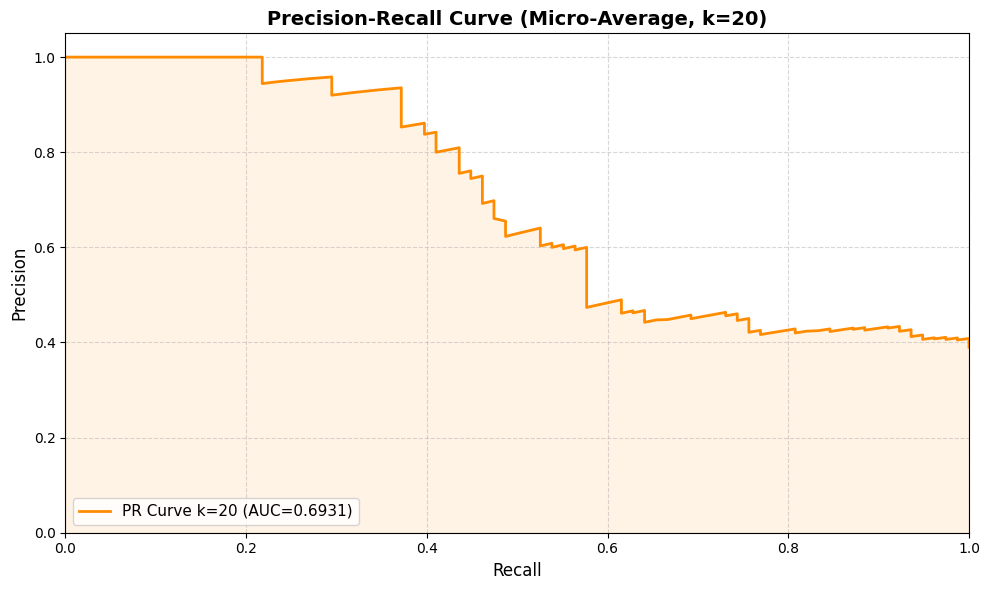

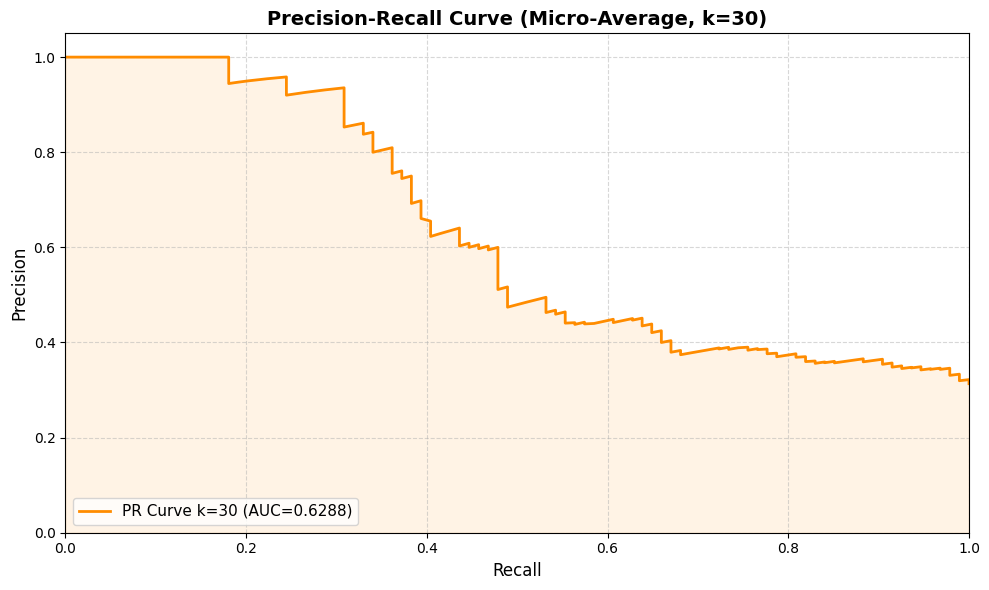

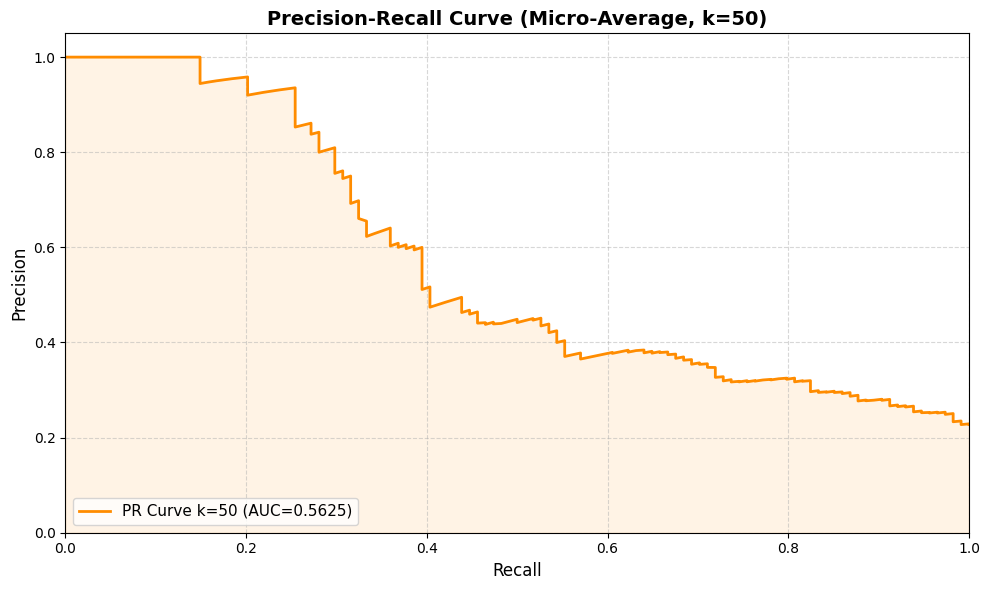

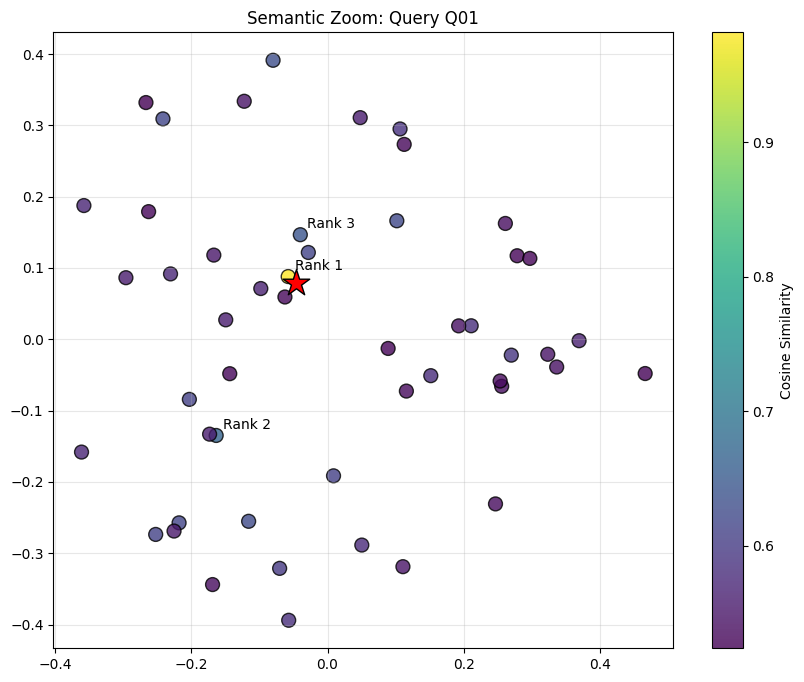

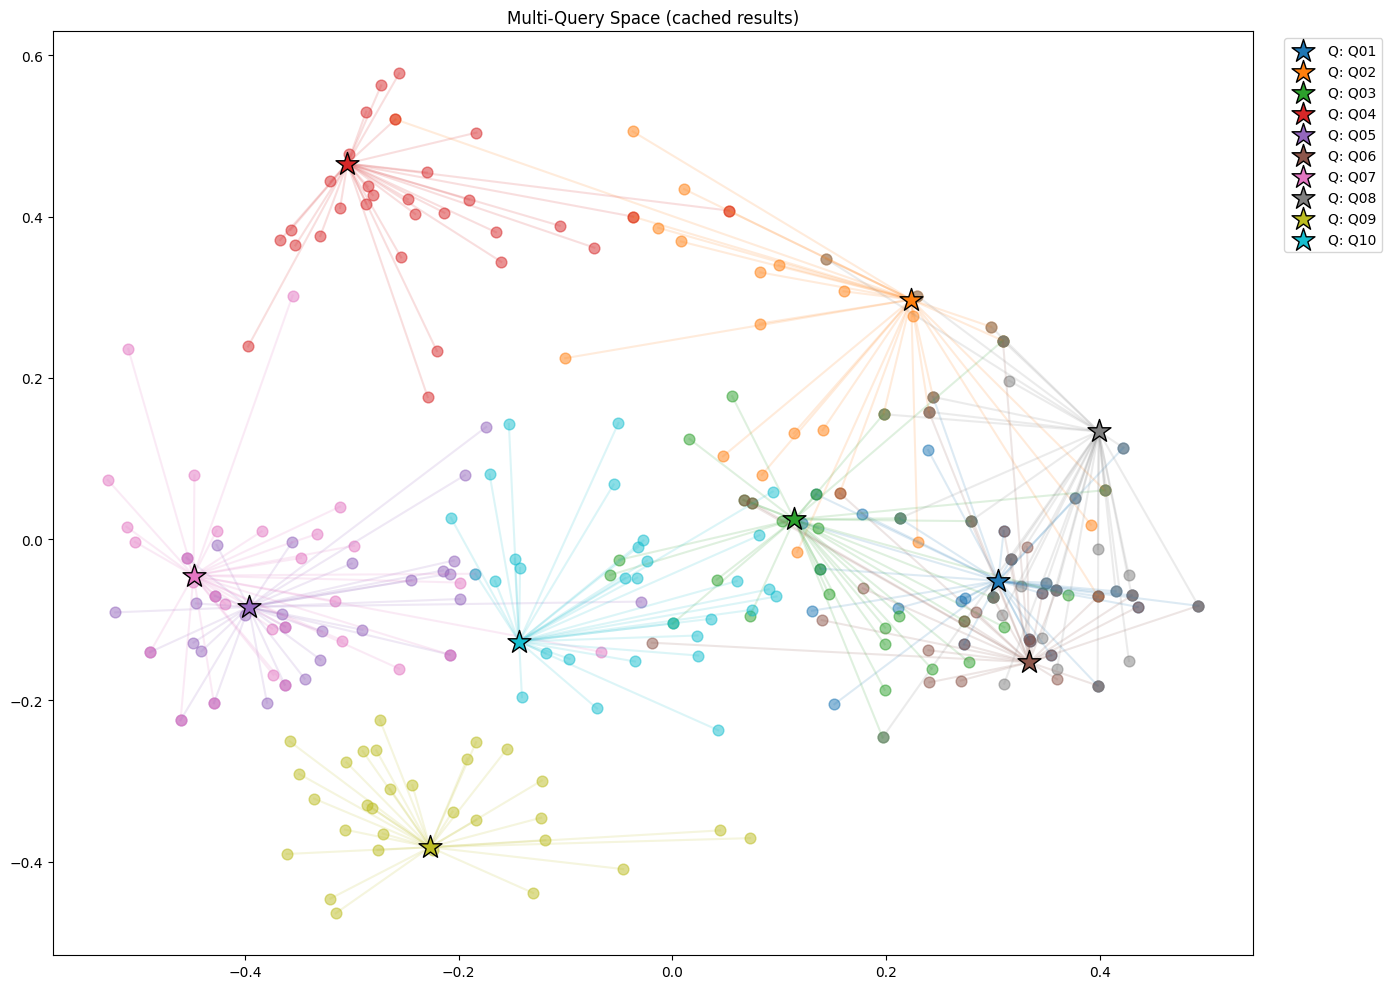


INSPECTION: Q01 (Top-20)
Query: eutravel optimodal european travel ecosystem eutravel aims t
------------------------------------------------------------
1. [OK] 193378 (Score: 0.9816) -> optimodal european travel ecosystem: eutravel aims to: 1. su...
2. [OK] 210137 (Score: 0.6673) -> mobility as a service in a multimodal european cross-border ...
3. [OK] 193715 (Score: 0.6432) -> data driven approach for a seamless efficient european trave...
4. [OK] 193373 (Score: 0.6295) -> information technologies for shift to rail: the it2rail - in...
5. [NO] 193722 (Score: 0.6264) -> mobility innovations for a new dawn in sustainable european ...
6. [OK] 206230 (Score: 0.6204) -> governance of the interoperability framework for rail and in...
7. [OK] 205685 (Score: 0.6169) -> advanced travel companion and tracking services: mankind s c...
8. [NO] 204144 (Score: 0.6154) -> civitas destinations: within the eu, and particularly follow...
9. [NO] 194890 (Score: 0.6138) -> users, safety, security and

In [8]:
if __name__ == "__main__":
    df_docs, df_queries = load_data()
    
    if df_docs is not None:

        model = SentenceTransformer(MODEL_NAME, device='cpu')
        
        doc_embeddings = model.encode(df_docs['clean_text'].tolist(), batch_size=128, show_progress_bar=True, normalize_embeddings=True)
        query_embeddings = model.encode(df_queries['clean_text'].tolist(), show_progress_bar=True, normalize_embeddings=True)
        
        d = doc_embeddings.shape[1]
        index = faiss.IndexFlatIP(d)
        index.add(doc_embeddings)

        MAX_K = 50 
        D, I = index.search(query_embeddings, MAX_K)
        
        save_and_eval_trec(D, I, df_docs, df_queries, k_list=[20, 30, 50])
        plot_pr_curve(k_list=[20, 30, 50])

        viz = SemanticVisualizer(model, df_docs, df_queries, doc_embeddings, D, I)
        viz.plot_single_query("Q01", k=50)
        viz.plot_multi_query(num_queries=10, k=30)
        
        for qid in df_queries['ID']:
            inspect_results_cached(str(qid), D, I, df_docs, df_queries, k=20)